## Mount Google Drive locally

Mount your Google Drive on your runtime using an authorization code



In [3]:
from google.colab import drive
drive.mount('/content/drive')

dataset_location = "/content/drive/My Drive/Crafting/ADLCV/dataset/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


***
## Import libraries and initialize values

* Line 16: prepare the ```path``` to the "Pokemon" folder in the Google Drive
* Line 17: define the input image ```dimension``` of the network
* Line 18: define the ```Batch Size```
* Line 19: define the number of ```Epochs```
* Line 24-25: initialize an empty array for ```data``` and ```labels```

In [4]:
import os
import cv2
import numpy as np
import tensorflow as tf
import numpy as np
import random
from imutils import paths
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import vgg16, resnet50
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras import models
from tensorflow.keras import layers

dataset_path = dataset_location + "pokemon"
IMAGE_DIMS = (224, 224, 3)
BS = 32
EPOCHS=50
print("Tensorflow version %s"%tf.__version__)
print("opencv version %s"%cv2.__version__)

# initialize the data and labels
data = []
labels = []

Tensorflow version 2.4.0
opencv version 4.1.2


***
## Prepare the input images / data

* Line 3: obtain the list of image filenames
* Line 4-5: shuffle (randomise) the list
* Line 7: loop through each image file
* Line 10: read the image
* Line 11: resize the image
* Line 12: convert the image from OpenCV format to normal array
* Line 13: add the image to the ```data``` array
* Line 17: extract the name only from the filename
* Line 18: add the name as label into the ```labels``` array

In [5]:
# grab the image paths and randomly shuffle them
print("[INFO] loading images...")
imagePaths = sorted(list(paths.list_images(dataset_path)))
random.seed(42)
random.shuffle(imagePaths)
# loop over the input images
for ind, imagePath in enumerate(imagePaths):
	# load the image, pre-process it, and store it in the data list
	print(ind, imagePath, imagePath.split(os.path.sep)[-2])
	image = cv2.imread(imagePath)
	image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
	image = img_to_array(image)
	data.append(image)
 
	# extract the class label from the image path and update the
	# labels list
	label = imagePath.split(os.path.sep)[-2]
	labels.append(label)

[INFO] loading images...
0 /content/drive/My Drive/Crafting/ADLCV/dataset/pokemon/pikachu/00000134.jpg pikachu
1 /content/drive/My Drive/Crafting/ADLCV/dataset/pokemon/pikachu/00000122.jpg pikachu
2 /content/drive/My Drive/Crafting/ADLCV/dataset/pokemon/pikachu/00000090.jpg pikachu
3 /content/drive/My Drive/Crafting/ADLCV/dataset/pokemon/pikachu/00000184.jpg pikachu
4 /content/drive/My Drive/Crafting/ADLCV/dataset/pokemon/pikachu/00000177.png pikachu
5 /content/drive/My Drive/Crafting/ADLCV/dataset/pokemon/pikachu/00000159.jpg pikachu
6 /content/drive/My Drive/Crafting/ADLCV/dataset/pokemon/bulbasaur/00000033.jpg bulbasaur
7 /content/drive/My Drive/Crafting/ADLCV/dataset/pokemon/bulbasaur/00000022.png bulbasaur
8 /content/drive/My Drive/Crafting/ADLCV/dataset/pokemon/mewtwo/00000147.png mewtwo
9 /content/drive/My Drive/Crafting/ADLCV/dataset/pokemon/mewtwo/00000179.jpg mewtwo
10 /content/drive/My Drive/Crafting/ADLCV/dataset/pokemon/mewtwo/00000200.jpg mewtwo
11 /content/drive/My Drive

* Line 2: normalize the image
* Line 2-3: convert the ```data``` and ```labels``` into *numpy* array
* Line 4-5: display the size of the ```data```

In [6]:
# scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)
print("[INFO] data matrix: {:.2f}MB".format(
	data.nbytes / (1024 * 1000.0)))

[INFO] data matrix: 1344.17MB


Neural network is not able to accept string (text) as labels, one-hot enconding is an approach to convert text into integer values.

* Line 2-3: Perform one-hot encoding on the ```labels```.



In [7]:
# binarize the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

* Line 3-4: perform train-test split

In [8]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data,
	labels, test_size=0.2, random_state=42)

***
## Prepare the model (using transfer learning)

* Line 5: obtain the VGG16 pre-trained model ***without*** the dense classification layers.
* Line 8: obtain the ResNet pre-trained model.
* Line 12-13: Set all the base pre-trained layer to be ***un-trainable***
* Line 16: Create the model and initialise it with the pre-trained layers
* Line 17-18: creating the desnse layers for classification
* Line 20-22: compile the model
* Line 24: display a summary of the model

In [22]:
# initialize the model
print("[INFO] compiling model...")

# Load VGG16 model without the top layers
#base_layers = vgg16.VGG16(include_top=False, input_shape=IMAGE_DIMS)

# Load ResNet50 model without the top layers
base_layers = resnet50.ResNet50(include_top=False, input_shape=IMAGE_DIMS)

# Allow fine tuning to go into the convolution layers
base_layers_to_train = 0
for i in range(0, len(base_layers.layers) - base_layers_to_train):
    base_layers.layers[i].trainable = False
for i in range(len(base_layers.layers) - base_layers_to_train, len(base_layers.layers)):
    base_layers.layers[i].trainable = True


hidden_layers_to_add = [] # No hidden layer
#hidden_layers_to_add = [128] # One hidden layer with 128 nodes
#hidden_layers_to_add = [128, 64] # Two hidden layers with 128 and 64 nodes respectively

# Create the network
network = models.Sequential(base_layers)
network.add(layers.Flatten())
for node in hidden_layers_to_add:
  network.add(layers.Dense(node, activation='sigmoid'))
network.add(layers.Dense(5, activation='softmax'))

network.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

network.summary()

[INFO] compiling model...
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_7 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_15 (Dense)             (None, 5)                 501765    
Total params: 24,089,477
Trainable params: 501,765
Non-trainable params: 23,587,712
_________________________________________________________________


***
## Perform training and testing

* Line 1: perform training
* Line 2: perform testing
* Line 3: display test result

In [23]:
%%time
history = network.fit(trainX, trainY, epochs=EPOCHS, batch_size=BS, verbose=2)
test_loss, test_acc = network.evaluate(testX, testY, verbose=2)
print('test_acc:', test_acc)

Epoch 1/50
29/29 - 6s - loss: 12.1724 - accuracy: 0.2309
Epoch 2/50
29/29 - 3s - loss: 7.3894 - accuracy: 0.2943
Epoch 3/50
29/29 - 3s - loss: 6.4283 - accuracy: 0.3359
Epoch 4/50
29/29 - 3s - loss: 5.8394 - accuracy: 0.3862
Epoch 5/50
29/29 - 3s - loss: 4.8940 - accuracy: 0.4420
Epoch 6/50
29/29 - 3s - loss: 4.1892 - accuracy: 0.5077
Epoch 7/50
29/29 - 3s - loss: 4.6653 - accuracy: 0.5011
Epoch 8/50
29/29 - 3s - loss: 3.8685 - accuracy: 0.5405
Epoch 9/50
29/29 - 3s - loss: 3.6141 - accuracy: 0.5525
Epoch 10/50
29/29 - 3s - loss: 3.9154 - accuracy: 0.5733
Epoch 11/50
29/29 - 3s - loss: 3.6225 - accuracy: 0.5733
Epoch 12/50
29/29 - 3s - loss: 3.4623 - accuracy: 0.6094
Epoch 13/50
29/29 - 3s - loss: 2.7585 - accuracy: 0.6400
Epoch 14/50
29/29 - 3s - loss: 3.6936 - accuracy: 0.5985
Epoch 15/50
29/29 - 3s - loss: 2.7256 - accuracy: 0.6346
Epoch 16/50
29/29 - 3s - loss: 2.9262 - accuracy: 0.6565
Epoch 17/50
29/29 - 3s - loss: 2.9523 - accuracy: 0.6608
Epoch 18/50
29/29 - 3s - loss: 2.7559 -

***
## Load an image for testing

* Line 2: load an image
* Line 6: resize the image
* Line 7: convert to *RGB* for display purpose (OpenCV format is *BGR*)
* Line 8: normalise the image
* Line 9-10: prepare the image into array

In [24]:
# load the image
image = cv2.imread(dataset_path + '/mewtwo/00000000.jpg')
#image = cv2.imread(dataset_path + '/pikachu/00000000.jpg')

# pre-process the image for classification
image = cv2.resize(image, (IMAGE_DIMS[0], IMAGE_DIMS[1]))
image_display = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = image.astype("float") / 255.0
image = img_to_array(image)
image = np.expand_dims(image, axis=0)

* Line 1-2: import matplotlib and set the output to within colab (inline)
* Line 6: Perform classification
* Line 7: obtain the ***```index```*** with the highest probability
* Line 8: Obtain the label of the ```index```
* Line 10-12: display image and predicted label

[INFO] classifying image...


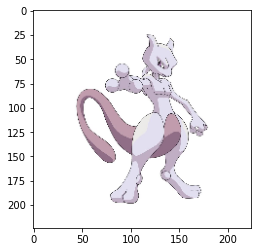

squirtle


In [25]:
%matplotlib inline
import matplotlib.pyplot as plt

# classify the input image
print("[INFO] classifying image...")
proba = network.predict(image)[0]
idx = np.argmax(proba)
label = lb.classes_[idx]

plt.imshow(image_display)
plt.show()
print(label)